In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Load datasets
customers = pd.read_csv('C:/Users/sunit/Desktop/eCommerce_Transaction Dataset/data/Customers.csv')
transactions = pd.read_csv('C:/Users/sunit/Desktop/eCommerce_Transaction Dataset/data/Transactions.csv')


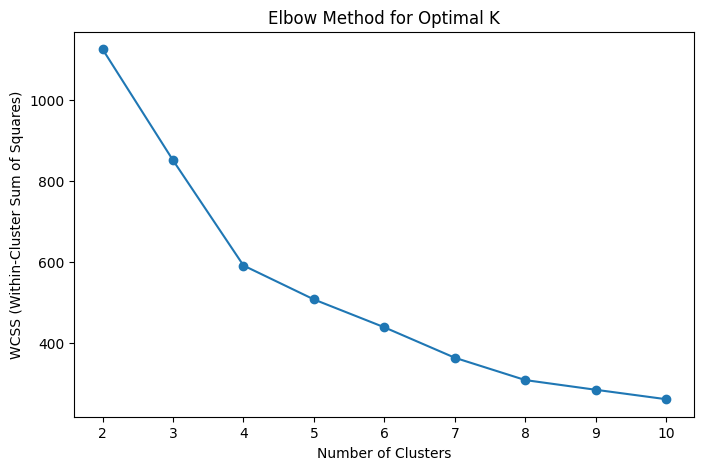

DB Index: 1.5064
Silhouette Score: 0.2357


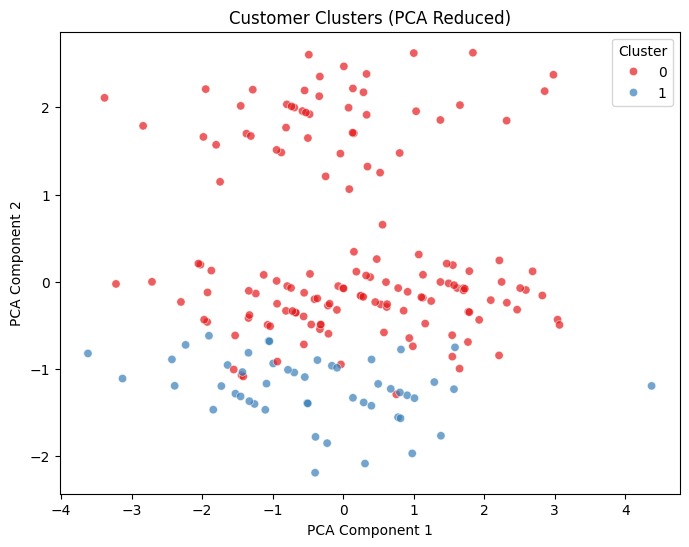

In [19]:
# Merge datasets on CustomerID
merged_data = transactions.merge(customers, on="CustomerID")

# Aggregate transaction data per customer
customer_summary = merged_data.groupby("CustomerID").agg(
    total_transactions=("TransactionID", "count"),
    total_spent=("TotalValue", "sum"),
    avg_spent_per_transaction=("TotalValue", "mean"),
    region=("Region", "first")
).reset_index()

# One-hot encode 'Region'
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_summary[['region']]).toarray()
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['region']))

# Combine features
features = pd.concat([customer_summary[['total_transactions', 'total_spent', 'avg_spent_per_transaction']], region_df], axis=1)

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal clusters using Elbow Method
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

# Choose optimal K (e.g., K=4 based on Elbow Method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)
customer_summary['Cluster'] = clusters

# Evaluate Clustering
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"DB Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Visualize Clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_summary['Cluster'], palette="Set1", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Clusters (PCA Reduced)")
plt.legend(title="Cluster")
plt.show()


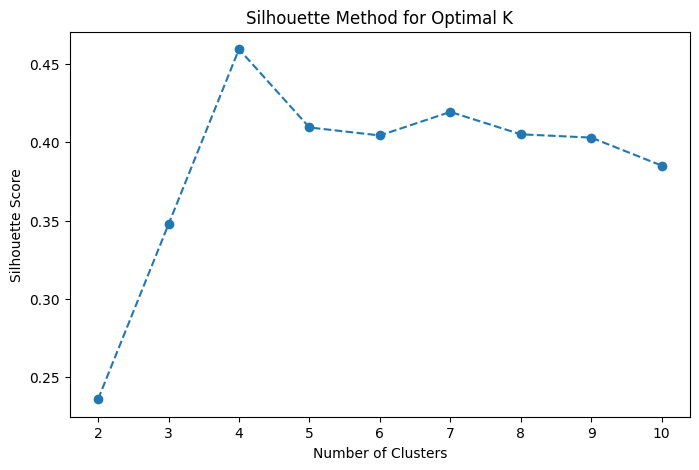

In [14]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='dashed')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.show()
